In [80]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sksurv.util import Surv 
from sklearn.model_selection import train_test_split

In [81]:
import yaml
import sys
sys.path.append('/home/gmarinos/Documents/Code/threshold_exceedance_forecasting/src/')
 
from synthetic_data_generation import *
from utils import *
from data_fetching import *
from dataset_construction import *
from main_classes.main_classes import *

In [82]:
# Step 1: Parse the YAML file
# Define the path to your config file
config_file_path = '/home/gmarinos/Documents/Code/threshold_exceedance_forecasting/config.yaml'

# Load the config file
with open(config_file_path, 'r') as config_file:
    config_data = yaml.safe_load(config_file)


In [83]:
import json

with open('/home/gmarinos/Documents/Code/extreme_value_prediction_experiments/jupyter_notebooks/Local_vs_global_forecasting/Datasets/top_10_series_data.json', 'r') as f:
    top_10 = json.loads(f.read())

In [84]:
top_10

{'fruits and vegetables': {'Date': {'0': '1991-04-01',
   '1': '1991-05-01',
   '2': '1991-06-01',
   '3': '1991-07-01',
   '4': '1991-08-01',
   '5': '1991-09-01',
   '6': '1991-10-01',
   '7': '1991-11-01',
   '8': '1991-12-01',
   '9': '1992-01-01',
   '10': '1992-02-01',
   '11': '1992-03-01',
   '12': '1992-04-01',
   '13': '1992-05-01',
   '14': '1992-06-01',
   '15': '1992-07-01',
   '16': '1992-08-01',
   '17': '1992-09-01',
   '18': '1992-10-01',
   '19': '1992-11-01',
   '20': '1992-12-01',
   '21': '1993-01-01',
   '22': '1993-02-01',
   '23': '1993-03-01',
   '24': '1993-04-01',
   '25': '1993-05-01',
   '26': '1993-06-01',
   '27': '1993-07-01',
   '28': '1993-08-01',
   '29': '1993-09-01',
   '30': '1993-10-01',
   '31': '1993-11-01',
   '32': '1993-12-01',
   '33': '1994-01-01',
   '34': '1994-02-01',
   '35': '1994-03-01',
   '36': '1994-04-01',
   '37': '1994-05-01',
   '38': '1994-06-01',
   '39': '1994-07-01',
   '40': '1994-08-01',
   '41': '1994-09-01',
   '42': '1

### Functions

In [85]:
def create_dataframe(num_lags, numbers, real_value, extreme_event, start, stop, duration):
    """
    Create a pandas DataFrame with lag columns and additional metadata.

    Parameters:
    - num_lags (int): Number of lag columns to create.
    - numbers (list): List of numerical values from which lag columns are derived.
    - real_value (list): List of real values to be included in the DataFrame.
    - extreme_event (list): List of extreme event indicators to be included.
    - start (list): List of start dates to be included.
    - stop (list): List of stop dates to be included.
    - duration (list): List of durations to be included.

    Returns:
    - df_new (pandas.DataFrame): A DataFrame containing lag columns, real_value,
      extreme_event, start_date, stop_date, and duration.

    Example Usage:
    num_lags = 3
    numbers = [10, 20, 30, 40, 50]
    real_value = [0.5, 0.6, 0.7, 0.8, 0.9]
    extreme_event = [False, False, True, True, False]
    start = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']
    stop = ['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06']
    duration = [2, 2, 2, 2, 2]
    df = create_dataframe(num_lags, numbers, real_value, extreme_event, start, stop, duration)
    """
    # Initialize a dictionary to store the lag columns
    lag_columns = {}

    # Create lag columns in the dictionary
    for lag in range(1, num_lags + 1):
        lag_columns[f'lag_{lag}'] = [arr[lag - 1] for arr in numbers]

    # Add other columns to the dictionary
    lag_columns['real_value'] = real_value
    lag_columns['extreme_event'] = extreme_event
    lag_columns['start_date'] = start
    lag_columns['stop_date'] = stop
    lag_columns['duration'] = duration

    # Convert the dictionary to a dataframe
    df_new = pd.DataFrame(lag_columns)

    return df_new

# the old name of this function was -> country_dataframe_cr
def duration_calculation(window_size, df, columns):
    """
    Calculate event durations and create a DataFrame with lag columns and additional metadata.

    Parameters:
    - window_size (int): Size of the time window for calculations.
    - df (pandas.DataFrame): DataFrame containing time series data.
    - columns (list): List of column names, where columns[0] corresponds to the time series data,
      and columns[1] corresponds to the event indicator.

    Returns:
    - df_new (pandas.DataFrame): A DataFrame containing lag columns, real_value,
      extreme_event, start_date, stop_date, and duration.

    Example Usage:
    window_size = 5
    data = pd.DataFrame({'Timestamp': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
                          'Value': [10, 20, 30, 40, 50],
                          'Event': [0, 0, 1, 1, 0]})
    columns = ['Value', 'Event']
    df = duration_calculation(window_size, data, columns)
    """
    #ts = df[df['country']==country]

    ts = df[columns].squeeze()
    print(ts)

    # Define the window size and the number of output steps
    output_steps = 1

    # Create input-output pairs from the time series using a sliding window
    numbers = []
    real_value = []
    extreme_event = []
    duration = []
    start = []
    stop = []

    print(ts.index[0])  
    print(type(print(ts.index[0])  ))
    start_date = ts.index[0]

    for i in range(len(ts)-window_size):
        
        numbers.append(ts[columns[0]][i:i+window_size].values)
        real_value.append(ts.iloc[i+window_size+output_steps-1][columns[0]])
        extreme_event.append(ts.iloc[i+window_size+output_steps-1][columns[1]])

        stop_date = ts.index[i+window_size+output_steps-1]

        if ts.iloc[i+window_size+output_steps-1][columns[1]] == 1:
        
          
          # Calculate the duration of the event
          duration.append((stop_date - start_date).days)

          #change the start date 
          start_date = ts.index[i+window_size+output_steps-1]

        else: 
          # Calculate the duration of the event
          duration.append((stop_date - start_date).days)

        # Extract the start and stop date of the time window
        start.append(start_date)
        stop.append(stop_date)
        

    # Convert the lists to a dataframe    
    df_new = create_dataframe(num_lags=window_size, 
                              numbers=numbers, 
                              real_value=real_value, 
                              extreme_event=extreme_event, 
                              start=start, 
                              stop=stop, 
                              duration=duration)

    return df_new


def extract_features(df, timesteps):
    """
    Extract time series features from a DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing time series data.
    - timesteps (int): Number of time steps to consider for feature extraction.

    Returns:
    - features_df (pandas.DataFrame): DataFrame containing extracted time series features.

    Example Usage:
    timesteps = 10
    features_df = extract_features(df, timesteps)
    """

    # Initialize empty lists to store the extracted features
    mean_list = []
    std_list = []
    minimum_list = []
    maximum_list = []
    percentiles_a_list = []
    percentiles_b_list = []
    percentiles_c_list = []
    skewness_list = []
    kurtosis_list = []
    autocorr_list = []
    partial_autocorr_list = []
    power_spectrum_list = []
    rolling_mean_list = []
    rolling_std_list = []
    #real_values = []

    # Iterate over each step in the time series dataset
    for i in range(len(df)):
        # Extract features using data up to the current step
        data_up_to_current_step = df['Incidents'][:i+timesteps]

        # Compute statistical features
        mean = data_up_to_current_step.mean()
        std = data_up_to_current_step.std()
        minimum = data_up_to_current_step.min()
        maximum = data_up_to_current_step.max()
        percentiles_a = data_up_to_current_step.quantile(0.25)
        percentiles_b = data_up_to_current_step.quantile(0.5)
        percentiles_c = data_up_to_current_step.quantile(0.75)
        skewness = data_up_to_current_step.skew()
        kurtosis = data_up_to_current_step.kurtosis()
        #real_value = df['Incidents'].iloc[i]

        # Compute autocorrelation features
        autocorr = data_up_to_current_step.autocorr()
        #partial_autocorr = pd.Series(sm.tsa.stattools.pacf(data_up_to_current_step))

        # Compute frequency domain features
        fft = np.fft.fft(data_up_to_current_step)
        power_spectrum = np.abs(fft) ** 2

        # Compute time domain features
        #rolling_mean = data_up_to_current_step.rolling(window=i+1).mean()
        #rolling_std = data_up_to_current_step.rolling(window=i+1).std()

        # Append the extracted features to the respective feature lists
        mean_list.append(np.round(mean,2))
        std_list.append(np.round(std,2))
        minimum_list.append(np.round(minimum,2))
        maximum_list.append(np.round(maximum,2))
        percentiles_a_list.append(np.round(percentiles_a,2))
        percentiles_b_list.append(np.round(percentiles_b,2))
        percentiles_c_list.append(np.round(percentiles_c,2))
        skewness_list.append(np.round(skewness,2))
        kurtosis_list.append(np.round(kurtosis,2))
        autocorr_list.append(np.round(autocorr,2))
        #partial_autocorr_list.append(partial_autocorr)
        power_spectrum_list.append(power_spectrum)
        #rolling_mean_list.append(rolling_mean)
        #rolling_std_list.append(rolling_std)
        #real_values.append(real_value)

    # Create a new DataFrame for the extracted features
    features_df = pd.DataFrame({
        'Mean': mean_list,
        'Standard Deviation': std_list,
        'Minimum': minimum_list,
        'Maximum': maximum_list,
        'Percentiles_a': percentiles_a_list,
        'Percentiles_b': percentiles_b_list,
        'Percentiles_c': percentiles_c_list,
        'Skewness': skewness_list,
        'Kurtosis': kurtosis_list,
        'Autocorrelation': autocorr_list#,
        #'Partial Autocorrelation': partial_autocorr_list,
        #'Power Spectrum': power_spectrum_list,
        #'Rolling Mean': rolling_mean_list,
        #'Rolling Standard Deviation': rolling_std_list
        #'Real_value': real_values,
        #'Date': df['Date']
    })

    return features_df 

### Dataset Creation

In [86]:
fruits_and_verg = pd.DataFrame(top_10['fruits and vegetables'])


In [87]:
fruits_and_verg['Date'] = pd.to_datetime(fruits_and_verg['Date'])
fruits_and_verg.set_index('Date', inplace=True)

In [88]:
fruits_and_verg.dtypes

Product      object
Incidents     int64
dtype: object

In [89]:
# Define the threshold for extreme events
threshold = fruits_and_verg['Incidents'].quantile(0.85)

# Create the 'extreme_event' column
fruits_and_verg['extreme_event'] = (fruits_and_verg['Incidents'] > threshold).astype(int)

In [90]:
fruits_and_verg

,Product,Incidents,extreme_event
Date,,,
1991-04-01,fruits and vegetables,1,0
1991-05-01,fruits and vegetables,0,0
1991-06-01,fruits and vegetables,0,0
1991-07-01,fruits and vegetables,0,0
1991-08-01,fruits and vegetables,0,0
...,...,...,...
2023-09-01,fruits and vegetables,170,1
2023-10-01,fruits and vegetables,180,1
2023-11-01,fruits and vegetables,331,1


In [91]:
timesteps = 10 

In [92]:
new_df = duration_calculation(window_size=timesteps, 
                              df=fruits_and_verg, 
                              columns=['Incidents', 'extreme_event'])

            Incidents  extreme_event
Date                                
1991-04-01          1              0
1991-05-01          0              0
1991-06-01          0              0
1991-07-01          0              0
1991-08-01          0              0
...               ...            ...
2023-09-01        170              1
2023-10-01        180              1
2023-11-01        331              1
2023-12-01        342              1
2024-01-01        172              1

[394 rows x 2 columns]
1991-04-01 00:00:00
1991-04-01 00:00:00
<class 'NoneType'>


In [93]:
test_size = 0.2 

validation_rows = round(fruits_and_verg.shape[0]*test_size)

##### Survival dataset

In [94]:
X_train_survival = new_df[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
X_test_survival = new_df[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
y_train_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[:-validation_rows].drop(columns=['real_value']))
y_test_survival = Surv.from_dataframe(event='extreme_event', time='duration', data=new_df[-validation_rows:].drop(columns=['real_value']))

##### Classification dataset 

In [95]:
X_train = new_df[:-validation_rows].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])
y_train, y_test = new_df['real_value'][:-validation_rows], new_df['real_value'][-validation_rows:]
X_test = new_df[-validation_rows:].drop(columns=['real_value', 'extreme_event', 'duration', 'start_date', 'stop_date'])

In [96]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sksurv.ensemble import ExtraSurvivalTrees, RandomSurvivalForest
from sksurv.util import Surv
from lightgbm import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


random_state = 42

list_of_models =   [DecisionTreeRegressor(random_state=random_state), 
                    RandomForestRegressor(random_state=random_state), 
                    SGDRegressor(random_state=random_state), 
                    KNeighborsRegressor(n_neighbors=3), 
                    AdaBoostRegressor(random_state=random_state),
                    BayesianRidge(), 
                    ExtraTreesRegressor(random_state=random_state),
                    BaggingRegressor(random_state=random_state), 
                    LGBMRegressor(objective="regression",random_state=random_state),
                    SVR(kernel="linear", C=0.025),
                    SVR(gamma=2, C=1),
                    #GaussianProcessRegressor(1.0 * RBF(1.0), random_state=random_state),
                    MLPRegressor(random_state=random_state),
                    # 'Prophet',
                    # 'hidden_markov_models',
                    'Survival_Analysis',
                    'Survival_Analysis_extracted_features',
                    # 'Prophet_simple_threshold'
                    ]

In [97]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from scipy.stats import norm, laplace, logistic, gumbel_r, lognorm, cauchy, genextreme 

distributions = [genextreme, norm, laplace, logistic, gumbel_r, lognorm, cauchy]

In [98]:
THRESHOLD = threshold

In [99]:
fruits_and_verg.reset_index()['Incidents']

0        1
1        0
2        0
3        0
4        0
      ... 
389    170
390    180
391    331
392    342
393    172
Name: Incidents, Length: 394, dtype: int64

In [100]:
fruits_and_verg

,Product,Incidents,extreme_event
Date,,,
1991-04-01,fruits and vegetables,1,0
1991-05-01,fruits and vegetables,0,0
1991-06-01,fruits and vegetables,0,0
1991-07-01,fruits and vegetables,0,0
1991-08-01,fruits and vegetables,0,0
...,...,...,...
2023-09-01,fruits and vegetables,170,1
2023-10-01,fruits and vegetables,180,1
2023-11-01,fruits and vegetables,331,1


In [101]:
extract_features(fruits_and_verg.reset_index().drop(columns=['Date',
                                                             'Product',
                                                             'extreme_event']), 
                                                             10)

,Mean,Standard Deviation,Minimum,Maximum,Percentiles_a,Percentiles_b,Percentiles_c,Skewness,Kurtosis,Autocorrelation
0,0.20,0.42,0,1,0.0,0.0,0.00,1.78,1.41,-0.19
1,0.18,0.40,0,1,0.0,0.0,0.00,1.92,2.04,-0.17
2,0.17,0.39,0,1,0.0,0.0,0.00,2.06,2.64,-0.15
3,0.15,0.38,0,1,0.0,0.0,0.00,2.18,3.22,-0.13
4,0.14,0.36,0,1,0.0,0.0,0.00,2.29,3.79,-0.12
...,...,...,...,...,...,...,...,...,...,...
389,58.01,62.86,0,433,3.0,43.5,88.75,1.84,5.63,0.88
390,58.01,62.86,0,433,3.0,43.5,88.75,1.84,5.63,0.88
391,58.01,62.86,0,433,3.0,43.5,88.75,1.84,5.63,0.88
392,58.01,62.86,0,433,3.0,43.5,88.75,1.84,5.63,0.88


In [102]:
import tsfel

def tsfel_feature_extraction(kind):

    '''
    kind(str): 'temporal', 'statistical' or 'spectral'
    '''

    if kind == 'temporal':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file
    if kind == 'statistical':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file
    if kind == 'spectral':
        cfg_file = tsfel.get_features_by_domain(kind)               # All features will be extracted.
        return cfg_file



In [103]:
fruits_and_verg.shape[0]/10

39.4

In [104]:
extracted_features = tsfel.time_series_features_extractor(tsfel_feature_extraction(kind='statistical'), 
                                               fruits_and_verg['Incidents'],  
                                               window_size=11, 
                                               overlap=0.95)    # Receives a time series sampled at 50 Hz, divides into windows of size 250 (i.e. 5 seconds) and extracts all features

*** Feature extraction started ***


/tmp/ipykernel_49912/1205181486.py:1: UserWarning: Using default sampling frequency set in configuration file.
  extracted_features = tsfel.time_series_features_extractor(tsfel_feature_extraction(kind='statistical'),
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/tsfel/feature_extraction/calc_features.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(signal_windows[0], pd.DataFrame):



*** Feature extraction finished ***


In [105]:
extracted_features

,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Peak to peak distance,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance
0,2.0,20.0,2.0,8.0,0.0,0.0,0.090909,0.181818,0.272727,0.363636,...,0.181818,0.297521,0.0,0.0,0.0,1.0,0.426401,1.649916,0.385695,0.148760
1,1.0,10.0,0.0,0.0,0.0,0.0,0.090909,0.181818,0.272727,0.363636,...,0.090909,0.165289,0.0,0.0,0.0,1.0,0.301511,2.846050,0.287480,0.082645
2,1.0,10.0,0.0,0.0,0.0,0.0,0.090909,0.181818,0.272727,0.363636,...,0.090909,0.165289,0.0,0.0,0.0,1.0,0.301511,2.846050,0.287480,0.082645
3,1.0,10.0,0.0,0.0,0.0,0.0,0.090909,0.181818,0.272727,0.363636,...,0.090909,0.165289,0.0,0.0,0.0,1.0,0.301511,2.846050,0.287480,0.082645
4,2.0,20.0,2.0,8.0,0.0,0.0,0.090909,0.181818,0.272727,0.363636,...,0.181818,0.297521,0.0,0.0,0.0,1.0,0.426401,1.649916,0.385695,0.148760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,313786.0,3137860.0,2.0,8.0,136.0,170.0,0.090909,0.181818,0.272727,0.363636,...,166.181818,22.198347,164.0,16.0,129.0,109.0,168.896418,1.121949,30.159630,909.603306
380,329545.0,3295450.0,2.0,8.0,148.0,171.0,0.090909,0.181818,0.272727,0.363636,...,170.818182,20.314050,168.0,18.0,136.0,102.0,173.085633,1.136425,27.924633,779.785124
381,417202.0,4172020.0,2.0,8.0,148.0,180.0,0.090909,0.181818,0.272727,0.363636,...,187.454545,38.661157,170.0,20.0,136.0,195.0,194.749723,1.736716,52.803863,2788.247934
382,515670.0,5156700.0,2.0,8.0,150.0,206.0,0.090909,0.181818,0.272727,0.363636,...,206.181818,53.173554,171.0,21.0,148.0,194.0,216.515798,1.218110,66.091972,4368.148760


In [106]:
X_train_extracted_features = extracted_features[:-validation_rows]
#y_train_extracted_features, y_test_extracted_features = extracted_features[:-validation_rows], new_df[-validation_rows:]
X_test_extracted_features = extracted_features[-validation_rows:]

In [107]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

print("\n")

print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)


print("\n")
print('X_train_survival shape', X_train_survival.shape)
print('y_train_survival shape', y_train_survival.shape)


print("\n")
print('X_test_survival shape', X_test_survival.shape)
print('y_test_survival shape', y_test_survival.shape)


print("\n")

print('X_train_extracted_features shape', X_train_extracted_features.shape)
print('X_test_extracted_features shape', X_test_extracted_features.shape)


X_train shape (305, 10)
y_train shape (305,)


X_test shape (79, 10)
y_test shape (79,)


X_train_survival shape (305, 10)
y_train_survival shape (305,)


X_test_survival shape (79, 10)
y_test_survival shape (79,)


X_train_extracted_features shape (305, 40)
X_test_extracted_features shape (79, 40)


In [109]:
X_train_extracted_features = X_train_extracted_features.fillna(0)
X_test_extracted_features = X_test_extracted_features.fillna(0)

In [110]:
import pickle 

trained_regressors = {} 
results = pd.DataFrame(index=y_test.index)
table_data = []


# Loop through models and distributions and evaluate each one
for regression in list_of_models:
    for distribution in distributions:
        if regression not in [#'Prophet', 
                              #'Prophet_simple_threshold', 
                              'Survival_Analysis', 
                              #'hidden_markov_models', 
                              'Survival_Analysis_extracted_features']:
            # Implement the model fitting and evaluation logic here
            # print('\n')
            # print('Distribution:', distribution.name)
            # print('Model:', str(regression))

            regression.fit(X_train, y_train)

            trained_regressors[str(regression)+'_'+str(distribution.name)]=[regression]

            # getting point forecasts
            point_forecasts = regression.predict(X_test)
            std = y_train.std()
            if distribution == lognorm:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, s=std) for x_ in point_forecasts])
            elif distribution == genextreme:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, c = -0.1, loc=x_, scale=std) for x_ in point_forecasts])
            elif distribution != lognorm:
                exceedance_prob = np.asarray([1 - distribution.cdf(THRESHOLD, loc=x_, scale=std) for x_ in point_forecasts])
            
            #y_test_ = new_df['marked'].loc[y_test.index]
            y_test_ = (y_test > THRESHOLD).astype(int)
            
            y_pred_binary = np.where(exceedance_prob >= 0.5, 1, 0)
            results['actual_predictions_from_model'+'_'+str(regression)+'_'+str(distribution.name)]  = point_forecasts
            results['y_pred_binary'+'_'+str(regression)+'_'+str(distribution.name)]  = y_pred_binary
            trained_regressors[str(regression)+'_'+str(distribution.name)].append(y_pred_binary)

            # Compute the confusion matrix
            cm = confusion_matrix(y_test_, y_pred_binary)

            # Compute the precision, recall, and F1 score
            accuracy = accuracy_score(y_test_, y_pred_binary)
            precision = precision_score(y_test_, y_pred_binary)
            recall = recall_score(y_test_, y_pred_binary)
            f1 = f1_score(y_test_, y_pred_binary)
            roc_auc = roc_auc_score(y_test_, exceedance_prob)

            # Print the results
            # print(f"Confusion Matrix:\n{cm}")
            # print(f"Accuracy: {accuracy:.2f}")
            # print(f"Precision: {precision:.2f}")
            # print(f"Recall: {recall:.2f}")
            # print(f"F1 Score: {f1:.2f}")
            # print(f"Roc AUC: {roc_auc:.2f}")

            table_data.append([THRESHOLD, 
                               timesteps, 
                               distribution.name, 
                               regression, 
                                str(int(np.round(accuracy, 2)*100))+str('%'), 
                                str(int(np.round(precision, 2)*100))+str('%'), 
                                str(int(np.round(recall, 2)*100))+str('%'), 
                                str(int(np.round(f1, 2)*100))+str('%'), 
                                str(int(np.round(roc_auc, 2)*100))+str('%'), 
                                test_size])
            
        
        if regression == 'Survival_Analysis':
                # Implement Survival Analysis logic here
                trained_regressors[str(regression)]=[regression]

                scores_cph_tree = {}
                scores_RandomSurvivalForest = {} 

                est_cph_tree = RandomSurvivalForest(random_state=random_state)
                for i in range(1, 61):
                    n_estimators = i * 5
                    est_cph_tree.set_params(n_estimators=n_estimators)
                    est_cph_tree.fit(X_train_survival, y_train_survival)
                    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test_survival, y_test_survival)
                    scores_RandomSurvivalForest['scores_cph_tree'+str(n_estimators)] =  pickle.dumps(est_cph_tree)
                

                metrics = []
                prob_percentages = [0.85, 0.90]

                for i in range(5, 61, 5):
                    for prob_percentage in prob_percentages:
                        list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_survival, return_array=True)

                        y_test_ = (y_test_survival['extreme_event'] == True).astype(int)
                        y_pred_binary = pd.DataFrame(list_of_lists[0:,0], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                        # Calculate metrics
                        accuracy = accuracy_score(y_test_, y_pred_binary)
                        precision = precision_score(y_test_, y_pred_binary)
                        recall = recall_score(y_test_, y_pred_binary)
                        f1 = f1_score(y_test_, y_pred_binary)
                        roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])
                        

                        metrics.append({'model':'scores_cph_tree'+str(i),
                                        'accuracy': accuracy,
                                        'precision': precision,
                                        'recall': recall,
                                        'roc_auc':roc_auc,
                                        'f1-score':f1,
                                        'y_pred_binary':y_pred_binary})

                        print(accuracy,'%', precision,'%', recall,'%', f1,'%', roc_auc,'%')

                # Sort the list based on the 'age' field
                sorted_data = sorted(metrics, key=lambda x: x['f1-score'], reverse=True)

                accuracy = sorted_data[0]['accuracy']
                precision = sorted_data[0]['precision']
                recall = sorted_data[0]['recall']    
                f1 = sorted_data[0]['f1-score']
                roc_auc = sorted_data[0]['roc_auc']

                trained_regressors[str(regression)].append(y_pred_binary)
                
                table_data.append([ THRESHOLD, 
                                   timesteps, 
                                   None, 
                                   regression+'_'+str(sorted_data[0]['model']), 
                                   str(int(np.round(accuracy,2)*100))+str('%'), 
                                   str(int(np.round(precision,2)*100))+str('%'), 
                                   str(int(np.round(recall,2)*100))+str('%'), 
                                   str(int(np.round(f1,2)*100))+str('%'), 
                                   str(int(np.round(roc_auc,2)*100))+str('%'), 
                                   test_size])

                
                trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])

        if regression=='Survival_Analysis_extracted_features':
            # Implement Survival Analysis logic here
            trained_regressors[str(regression)]=[regression]

            scores_cph_tree = {}
            scores_RandomSurvivalForest = {} 

            est_cph_tree = RandomSurvivalForest(random_state=random_state)
            for i in range(1, 61):
                n_estimators = i * 5
                est_cph_tree.set_params(n_estimators=n_estimators)
                est_cph_tree.fit(X_train_extracted_features, y_train_survival)
                scores_cph_tree[n_estimators] = est_cph_tree.score(X_test_extracted_features, y_test_survival)
                scores_RandomSurvivalForest['scores_cph_tree'+str(n_estimators)] =  pickle.dumps(est_cph_tree)

            metrics = []
            prob_percentages = [0.85, 0.90]

            for i in range(5, 61, 5):
                for prob_percentage in prob_percentages:
                    list_of_lists = pickle.loads(scores_RandomSurvivalForest['scores_cph_tree'+str(i)]).predict_survival_function(X_test_extracted_features, return_array=True)

                    y_test_ = (y_test_survival['extreme_event'] == True).astype(int)
                    y_pred_binary = pd.DataFrame(list_of_lists[0:,0], columns=['probabilities'])['probabilities'].apply(lambda x: 1 if x < prob_percentage else 0).values

                    # Calculate metrics
                    accuracy = accuracy_score(y_test_, y_pred_binary)
                    precision = precision_score(y_test_, y_pred_binary)
                    recall = recall_score(y_test_, y_pred_binary)
                    f1 = f1_score(y_test_, y_pred_binary)
                    roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])
                    

                    metrics.append({'model':'scores_cph_tree'+str(i),
                                    'accuracy': accuracy,
                                    'precision': precision,
                                    'recall': recall,
                                    'roc_auc':roc_auc,
                                    'f1-score':f1,
                                    'y_pred_binary':y_pred_binary})

                    print(accuracy,'%', precision,'%', recall,'%', f1,'%', roc_auc,'%')

            # Sort the list based on the 'age' field
            sorted_data = sorted(metrics, key=lambda x: x['f1-score'], reverse=True)

            accuracy = sorted_data[0]['accuracy']
            precision = sorted_data[0]['precision']
            recall = sorted_data[0]['recall']    
            f1 = sorted_data[0]['f1-score']
            roc_auc = sorted_data[0]['roc_auc']

            trained_regressors[str(regression)].append(y_pred_binary)
            
            table_data.append([ THRESHOLD, 
                                timesteps, 
                                None, 
                                regression+'_'+str(sorted_data[0]['model']), 
                                str(int(np.round(accuracy,2)*100))+str('%'), 
                                str(int(np.round(precision,2)*100))+str('%'), 
                                str(int(np.round(recall,2)*100))+str('%'), 
                                str(int(np.round(f1,2)*100))+str('%'), 
                                str(int(np.round(roc_auc,2)*100))+str('%'), 
                                test_size])

            
            trained_regressors[str(regression)].append([accuracy, precision, recall, f1, roc_auc])

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 305, number of used features: 10
[LightGBM] [Info] Start training from score 37.393443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/tmp/ipykernel_49912/4037022217.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results['actual_predictions_from_model'+'_'+str(regression)+'_'+str(distribution.name)]  = point_forecasts
/tmp/ipykernel_49912/4037022217.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results['y_pred_binary'+'_'+str(regression)+'_'+str(distribution.name)]  = y_pred_binary
/tmp/ipykernel_49912/4037022217.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1876750700280112 %
0.3417721518

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.354430379

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.354430379

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.354430379

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17121848739495799 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1764705882352941 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.1764705882352941 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1876750700280112 %
0.3417721518

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.354430379

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.22408963585434172 %
0.45569620253164556 % 0.9 % 0.17647058823529413 % 0.2950819672131148 % 0.22408963585434172 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.15826330532212884 %
0.379746835443038 % 0.75 % 0.058823529411764705 % 0.10909090909090909 % 0.15826330532212884 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.1722689075630252 %
0.379746835443038 % 1.0 % 0.0392156862745098 % 0.07547169811320754 % 0.1722689075630252 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.16386554621848742 %
0.3670886075949367 % 1.0 % 0.0196078431372549 % 0.038461538461538464 % 0.16386554621848742 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17892156862745096 %
0.35443037974683544 % 0.5 % 0.0196078431372549 % 0.03773584905660377 % 0.17892156862745096 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.18067226890756302 %
0.354430379

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.1764705882352941 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %
0.34177215189873417 % 0.0 % 0.0 % 0.0 % 0.17577030812324929 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.428921568627451 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.428921568627451 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43487394957983194 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4327731092436975 %


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.532563025210084 %
0.3670886075949367 % 0.6666666666666666 % 0.0392156862745098 % 0.07407407407407407 % 0.532563025210084 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.43977591036414565 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.4474789915966386 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.44152661064425774 %
0.35443037974683544 % 0.0 % 0.0 % 0.0 % 0.42647058823529416 %
0.35443037974683544 % 0.0 % 0.0 %

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
trained_regressors

{'DecisionTreeRegressor(random_state=42)_genextreme': [DecisionTreeRegressor(random_state=42),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1])],
 'DecisionTreeRegressor(random_state=42)_norm': [DecisionTreeRegressor(random_state=42),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'DecisionTreeRegressor(random_state=42)_laplace': [DecisionTreeRegressor(random_state=42),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 0, 0

In [111]:
from tabulate import tabulate

print(tabulate(table_data, headers=[
                                    "Threshold", 
                                    "Number of lags", 
                                    "Distribution", 
                                    "Algorithm", 
                                    "Accuracy", 
                                    "Precision", 
                                    "Recall", 
                                    "F1-score", 
                                    'Roc AUC', 
                                    'Test size'], tablefmt="grid"))

+-------------+------------------+----------------+--------------------------------------------------------+------------+-------------+----------+------------+-----------+-------------+
|   Threshold |   Number of lags | Distribution   | Algorithm                                              | Accuracy   | Precision   | Recall   | F1-score   | Roc AUC   |   Test size |
+=============+==================+================+========================================================+============+=============+==========+============+===========+=============+
|       123.1 |               10 | genextreme     | DecisionTreeRegressor(random_state=42)                 | 48%        | 75%         | 28%      | 42%        | 51%       |         0.2 |
+-------------+------------------+----------------+--------------------------------------------------------+------------+-------------+----------+------------+-----------+-------------+
|       123.1 |               10 | norm           | DecisionTreeRegres

In [116]:
est_cph_tree = RandomSurvivalForest(random_state=random_state)
for i in range(1, 61, 5):
    n_estimators = i*20
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train_extracted_features, y_train_survival)
    print(est_cph_tree.score(X_test_extracted_features, y_test_survival))

0.5188811188811189
0.5375291375291376
0.5312354312354313
0.5391608391608391
0.5391608391608391
0.541958041958042
0.5400932400932401
0.541958041958042
0.5452214452214452
0.5424242424242425
0.5358974358974359
0.5354312354312354


In [117]:
est_cph_tree = ExtraSurvivalTrees(random_state=random_state)
for i in range(1, 61, 5):
    n_estimators = i*20
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train_extracted_features, y_train_survival)
    print(est_cph_tree.score(X_test_extracted_features, y_test_survival))

0.5582750582750583
0.5403263403263403
0.5405594405594406
0.5237762237762238
0.5083916083916084
0.5205128205128206
0.5144522144522145
0.5158508158508158
0.5177156177156177
0.5125874125874126
0.5093240093240093
0.5200466200466201


In [142]:
from sksurv.svm import FastKernelSurvivalSVM, FastSurvivalSVM, NaiveSurvivalSVM

est_cph_tree = FastSurvivalSVM(random_state=42)
# for i in range(1, 61, 5):
#     n_estimators = i*20
# est_cph_tree.set_params(n_estimators=n_estimators)
est_cph_tree.fit(X_train_extracted_features, y_train_survival)
print(est_cph_tree.score(X_test_extracted_features, y_test_survival))

0.668997668997669


In [156]:
ratings = est_cph_tree.predict(X_test_extracted_features)
                    

In [158]:
X_test_extracted_features_ = pd.DataFrame(X_test_extracted_features)
X_test_extracted_features_['ratings'] = ratings

In [159]:
X_test_extracted_features_

,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Peak to peak distance,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance,ratings
305,87855.0,878550.0,2.0,8.0,70.0,91.0,0.090909,0.181818,0.272727,0.363636,...,12.380165,87.0,9.0,60.0,68.0,89.369000,0.760897,17.051211,290.743802,0.870242
306,94056.0,940560.0,2.0,8.0,78.0,97.0,0.090909,0.181818,0.272727,0.363636,...,11.256198,87.0,9.0,70.0,58.0,92.469159,1.060755,14.826824,219.834711,0.931666
307,92872.0,928720.0,2.0,8.0,70.0,97.0,0.090909,0.181818,0.272727,0.363636,...,11.867769,87.0,10.0,70.0,58.0,91.885304,0.871022,15.634249,244.429752,0.919937
308,93952.0,939520.0,2.0,8.0,70.0,97.0,0.090909,0.181818,0.272727,0.363636,...,11.735537,91.0,8.0,70.0,58.0,92.418023,0.772335,15.605678,243.537190,0.930635
309,93193.0,931930.0,2.0,8.0,70.0,97.0,0.090909,0.181818,0.272727,0.363636,...,11.471074,91.0,8.0,70.0,55.0,92.043962,0.623466,14.971598,224.148760,0.923117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,313786.0,3137860.0,2.0,8.0,136.0,170.0,0.090909,0.181818,0.272727,0.363636,...,22.198347,164.0,16.0,129.0,109.0,168.896418,1.121949,30.159630,909.603306,3.108187
380,329545.0,3295450.0,2.0,8.0,148.0,171.0,0.090909,0.181818,0.272727,0.363636,...,20.314050,168.0,18.0,136.0,102.0,173.085633,1.136425,27.924633,779.785124,3.264286
381,417202.0,4172020.0,2.0,8.0,148.0,180.0,0.090909,0.181818,0.272727,0.363636,...,38.661157,170.0,20.0,136.0,195.0,194.749723,1.736716,52.803863,2788.247934,4.132568
382,515670.0,5156700.0,2.0,8.0,150.0,206.0,0.090909,0.181818,0.272727,0.363636,...,53.173554,171.0,21.0,148.0,194.0,216.515798,1.218110,66.091972,4368.148760,5.107938


In [163]:
true_false = []

for i in y_test_survival:
    true_false.append(i[0])

In [183]:
q = X_test_extracted_features_['ratings'].quantile(0.60)

In [184]:
y_test_ = (y_test_survival['extreme_event'] == True).astype(int)
y_pred_binary = (X_test_extracted_features_['ratings']>q).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_, y_pred_binary)
precision = precision_score(y_test_, y_pred_binary)
recall = recall_score(y_test_, y_pred_binary)
f1 = f1_score(y_test_, y_pred_binary)
# roc_auc = roc_auc_score(y_test_, list_of_lists[0:,0])

In [185]:
print(accuracy, 
      precision, 
      recall, 
      f1)

0.6075949367088608 0.8125 0.5098039215686274 0.6265060240963856


In [186]:
print('zeros are:', len(fruits_and_verg[fruits_and_verg['extreme_event']==0]), 'in', len(fruits_and_verg), 'so the percentage is:', np.round(len(fruits_and_verg[fruits_and_verg['extreme_event']==0])/len(fruits_and_verg) * 100, 2), '%')

zeros are: 335 in 394 so the percentage is: 85.03 %


<AxesSubplot:xlabel='Date'>

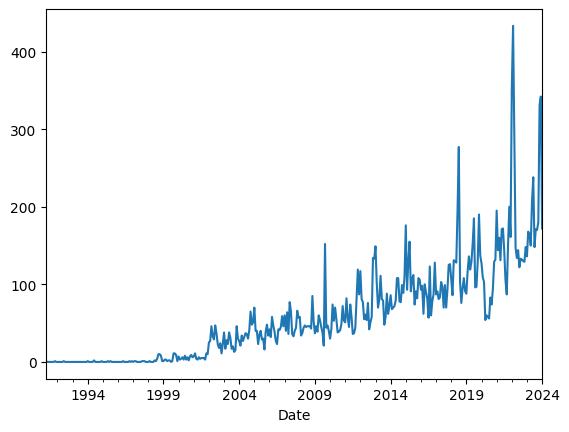

In [118]:
fruits_and_verg['Incidents'].plot()